In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/bitmusic38/bin/python


In [2]:
import numpy as np

import torch
import torch.nn as nn

import pretty_midi
import librosa

from music21 import midi

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

In [3]:
"""

    where am i?
    
"""

PATH = os.getcwd() + '/'
data_path = PATH + 'data/'
midi_path = data_path + '/nesmdb_midi/train/'
test_path = data_path + '/nesmdb_midi/test/'
output_path = data_path + 'output/'
model_path = PATH + 'model/'

print(f'PATH: {PATH}')
print(f'data path: {data_path}')
print(f'midi path: {midi_path}')
print(f'output path: {output_path}')
print(f'model path: {model_path}')

PATH: /Users/no_lineal/Documents/GitHub/mir_project/
data path: /Users/no_lineal/Documents/GitHub/mir_project/data/
midi path: /Users/no_lineal/Documents/GitHub/mir_project/data//nesmdb_midi/train/
output path: /Users/no_lineal/Documents/GitHub/mir_project/data/output/
model path: /Users/no_lineal/Documents/GitHub/mir_project/model/


In [4]:
"""

    device

"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'device: {device}')

device: cpu


In [5]:
""" 

    load midi files

"""

train_space = sorted(os.listdir( midi_path ))
test_space = sorted(os.listdir( test_path ))

print(f'sample space size: {len(train_space)}')
print(f'test space size: {len(test_space)}')

midi_train = {}
midi_test = {}

midi_error = []

for s in tqdm( train_space ):

    try:
        
        # piano roll representation
        aux = pretty_midi.PrettyMIDI( midi_path + s ).get_piano_roll( fs=100 )

        if aux.shape[1] > 0:
            midi_train[ s ] = aux
        else: 
            midi_error.append(s)
        
    except:
        
        #print(f'error: {s}')
        midi_error.append(s)

for s in tqdm( test_space ):

    try:

        # piano roll representation
        aux = pretty_midi.PrettyMIDI( test_path + s ).get_piano_roll( fs=100 )

        if aux.shape[1] > 0:
            midi_test[ s ] = aux
        else: 
            midi_error.append(s)

    except:
            
            #print(f'error: {s}')
            midi_error.append(s)

print('\n')
print(f'train space: {len(midi_train)}')
print(f'test space: {len(midi_test)}')
print(f'corrupted files: {len(midi_error)}')
print('\n')

sample space size: 4502
test space size: 373


100%|██████████| 373/373 [00:07<00:00, 52.45it/s]



train space: 4470
test space: 372
corrupted files: 33




In [6]:
""" 

    vanilla vae

"""

class Encoder( nn.Module ):

    def __init__( self, input_dim, hidden_dim, latent_dim ):

        super( Encoder, self ).__init__()

        self.fc1 = nn.Linear( input_dim, hidden_dim )
        self.fc2 = nn.Linear( hidden_dim, hidden_dim )
        self.fc3 = nn.Linear( hidden_dim, latent_dim ) 
        self.fc4 = nn.Linear( hidden_dim, latent_dim )

        self.relu = nn.ReLU(0.2)
        self.training = True

    def forward( self, x ):

        x = self.relu( self.fc1( x ) )
        x = self.relu( self.fc2( x ) )

        mu = self.fc3( x )
        logvar = self.fc4( x )

        return mu, logvar
    
class Decoder( nn.Module ):

    def __init__( self, latent_dim, hidden_dim, output_dim ):

        super( Decoder, self ).__init__()

        self.fc1 = nn.Linear( latent_dim, hidden_dim )
        self.fc2 = nn.Linear( hidden_dim, hidden_dim )
        self.fc3 = nn.Linear( hidden_dim, output_dim )

        self.relu = nn.ReLU(0.2)

    def forward( self, x ):

        x = self.relu( self.fc1( x ) )
        x = self.relu( self.fc2( x ) )

        x = self.fc3( x )

        x_hat = torch.sigmoid( x )

        return x_hat
    
class VAE( nn.Module ):

    def __init__( self, Encoder, Decoder ):

        super( VAE, self ).__init__()

        self.encoder = Encoder
        self.decoder = Decoder

    def reparametrization( self, mu, logvar ):

        eps = torch.randn_like( logvar ).to(device)
        z = mu + (eps * torch.exp(0.5 * logvar))

        return z
    
    def forward( self, x ):

        mean, logvar = self.encoder( x )
        z = self.reparametrization( mean, logvar )

        x_hat = self.decoder( z )

        return x_hat, mean, logvar

In [7]:
""" 

    load model

"""

latent_dim = 2

encoder = Encoder( input_dim=128*128, hidden_dim=512, latent_dim=latent_dim ).to(device)
decoder = Decoder( latent_dim=latent_dim, hidden_dim=512, output_dim=128*128 ).to(device)

model = VAE( encoder, decoder ).to(device)

model.load_state_dict( torch.load( model_path + 'vae_02.pth', map_location=torch.device('cpu') ) )

print('model loaded')
model.eval()

model loaded


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=16384, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=2, bias=True)
    (fc4): Linear(in_features=512, out_features=2, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=16384, bias=True)
    (relu): ReLU(inplace=True)
  )
)

In [28]:
""" 

    input processing

"""

def input_logspec( midi_file ):
        
        # log-frequency spectogram
        log_spec_db = librosa.amplitude_to_db(
            librosa.feature.melspectrogram(
                y=None, 
                sr=100, 
                S=midi_file.T, 
                n_fft=1024, 
                hop_length=512, 
                power=2.0, 
                n_mels=128), 
            ref=1.0
        )

        eps = 1e-38
        log_spec_db = torch.from_numpy( log_spec_db ).float()#.unsqueeze(0)  # add channel dimension
        log_spec_norm = ( log_spec_db - torch.min(log_spec_db) ) / ( torch.max(log_spec_db) - torch.min(log_spec_db) + eps)
        #log_spec_norm = log_spec_norm.unsqueeze(0)

        return log_spec_db,log_spec_norm


aux_train = np.random.choice( list( midi_train ) )
aux_test = np.random.choice( list( midi_test ) )

train_sample = midi_train[  aux_train ]
test_sample = midi_test[ aux_test ]

print(f'train sample: {aux_train}')
print(f'test sample: {aux_test}')

train_db, train_sample = input_logspec( train_sample )
_, test_sample = input_logspec( test_sample )

print('\n')
print(f'train logsep shape: {train_sample.shape}')
print(f'test logsep shape: {test_sample.shape}')
print('\n')

train sample: 222_MarusanoOnna_06_07MisbeliefLandInvestigationStaffBGM.mid
test sample: 338_TerraCresta_02_03Restart.mid


train logsep shape: torch.Size([128, 128])
test logsep shape: torch.Size([128, 128])




In [29]:
""" 

    generate

"""

with torch.no_grad():

    eps = 1e-38

    x = train_sample.to(device)
    x_hat, mean, logvar = model( x.view(-1, 128*128) )
    x_hat = x_hat.view(128, 128).cpu().numpy()

    print(f'x: {x.shape}')
    print(f'x_hat: {x_hat.shape}')

x: torch.Size([128, 128])
x_hat: (128, 128)


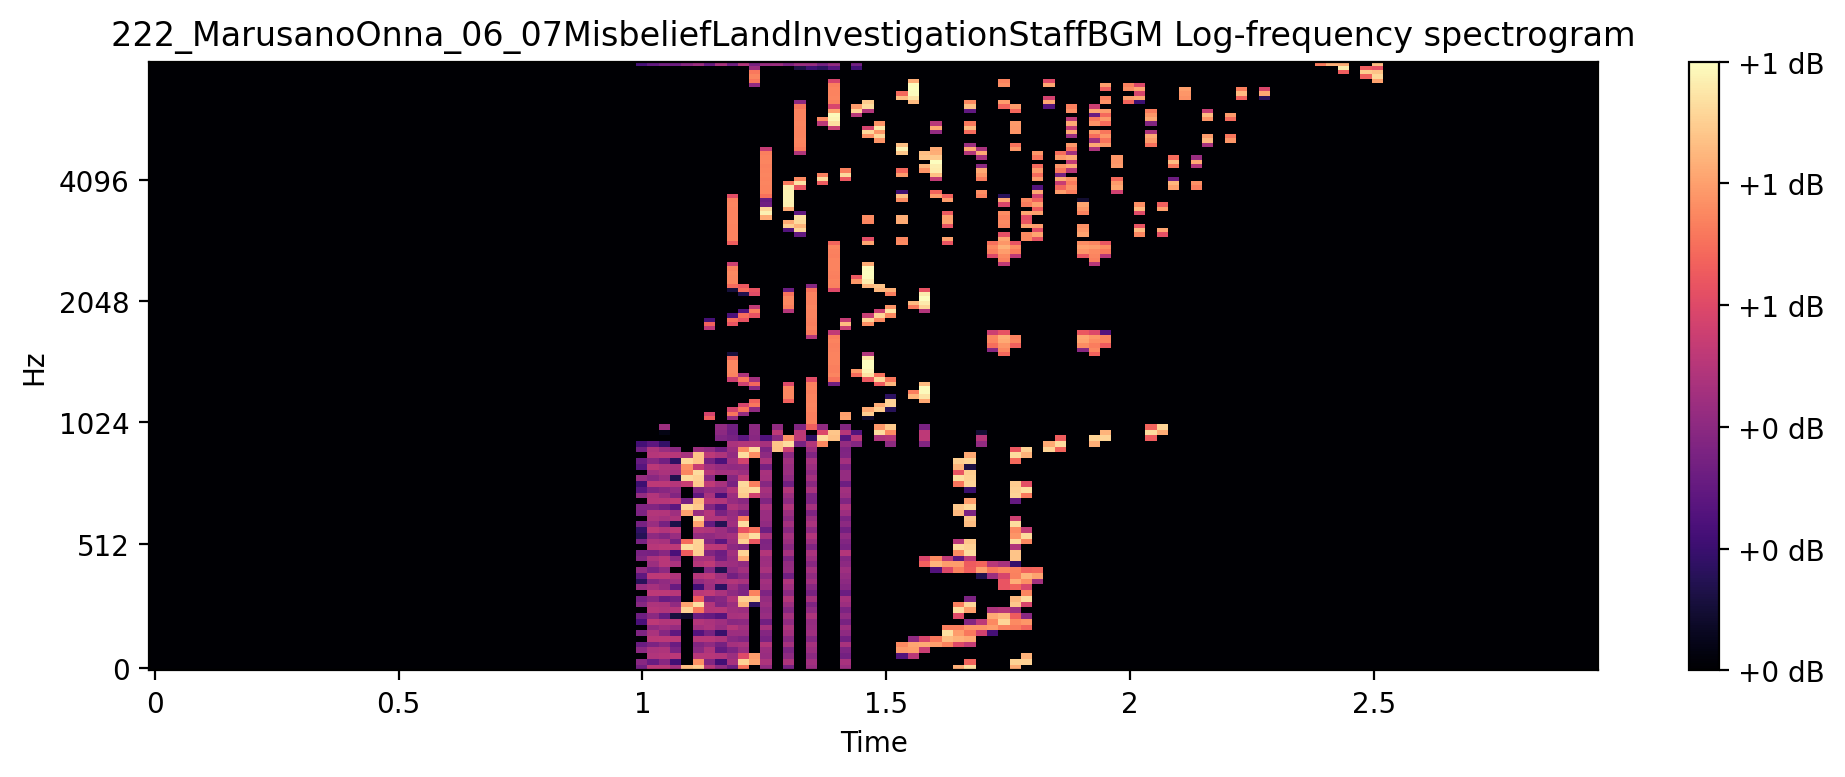

In [30]:
"""

    train viz spectogram

"""

plt.figure(figsize=(10, 4))
librosa.display.specshow( train_sample.numpy(), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{aux_train.replace(".mid", "")} Log-frequency spectrogram')
plt.tight_layout()
plt.show()

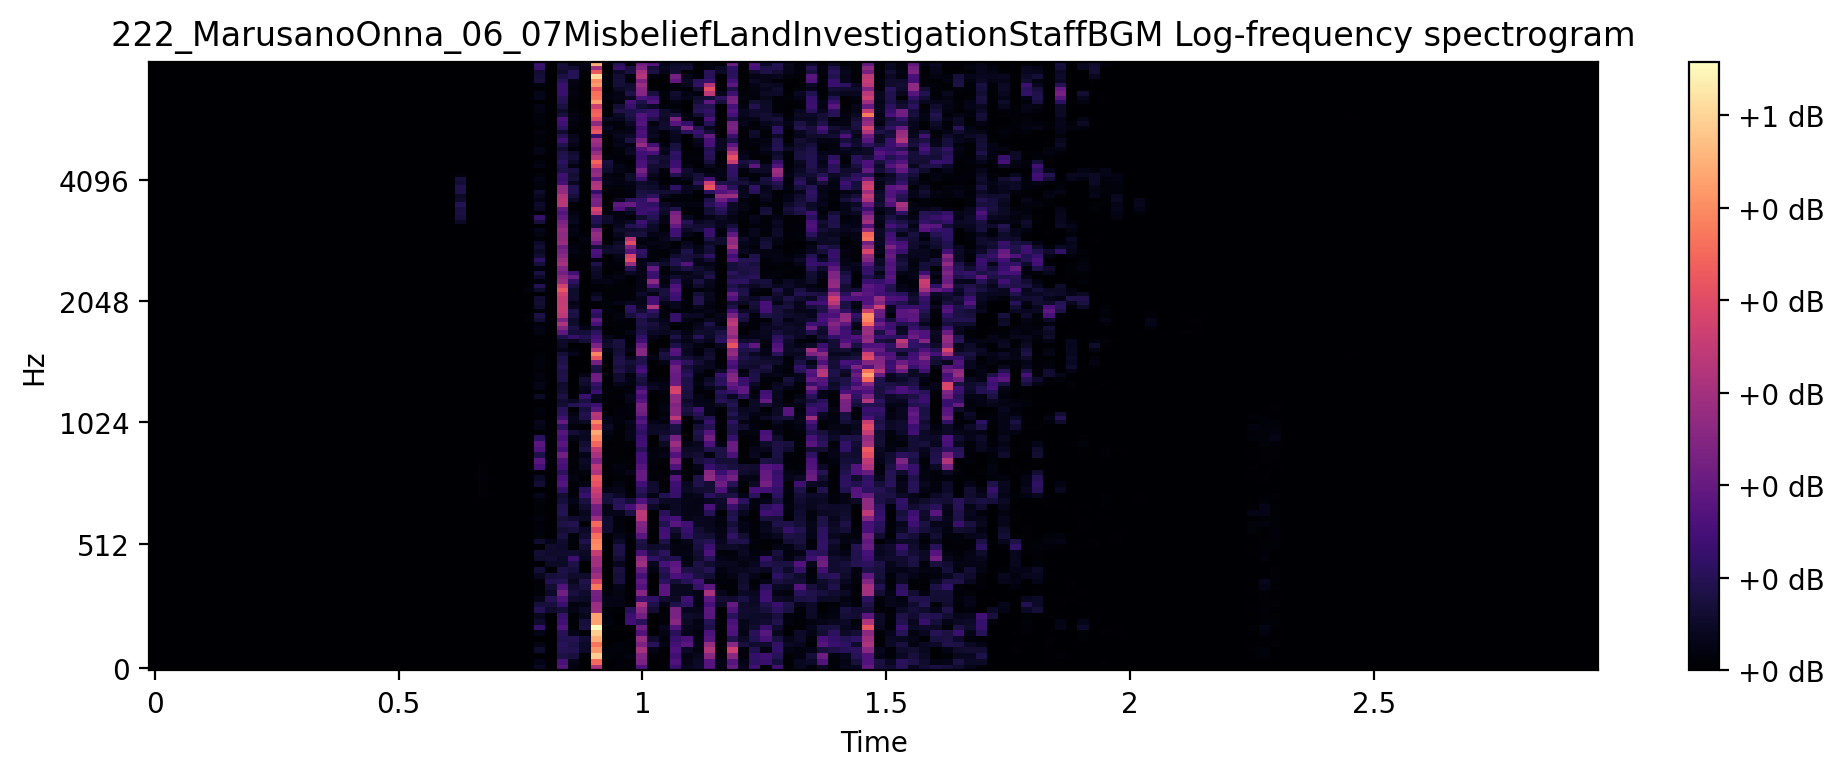

In [31]:
"""

    test viz spectogram

"""

plt.figure(figsize=(10, 4))
librosa.display.specshow( x_hat, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'{aux_train.replace(".mid", "")} Log-frequency spectrogram')
plt.tight_layout()
plt.show()

In [12]:
"""

    midi audio

"""

mf = midi.MidiFile()
mf.open( midi_path + aux_train )
mf.read()
mf.close()

s = midi.translate.midiFileToStream(mf)
s.show('midi')